In [1]:
import time
import random
import numpy as np
import importlib

import sys
sys.path.append("../../")

In [2]:
from qiskit import QuantumProgram
import Qconfig

In [3]:
import tools.Experiment_tools as exptool

In [4]:
importlib.reload(exptool)

<module 'tools.Experiment_tools' from '/Users/cvuillot/Work/Programming/IBMQE/qiskit-sdk-py/examples/experimenting_with_fault_tolerance/tools/Experiment_tools.py'>

In [5]:
qprogram = QuantumProgram()
qprogram.set_api(Qconfig.APItoken, Qconfig.config["url"])

In [6]:
api = qprogram.get_api()

In [7]:
qprogram.available_backends()

['ibmqx4',
 'ibmqx2',
 'ibmqx5',
 'ibmqx_qasm_simulator',
 'local_qasm_simulator',
 'local_unitary_simulator']

In [8]:
print(qprogram.get_backend_status("ibmqx4"))
api.get_my_credits()

{'available': True, 'busy': False, 'pending_jobs': 98, 'backend': 'ibmqx4'}


{'maxUserType': 150, 'promotional': 100, 'remaining': 0}

In [9]:
config = qprogram.get_backend_configuration("ibmqx4",list_format=True)
config

{'basis_gates': 'SU2+CNOT',
 'chip_name': 'Raven',
 'coupling_map': [[1, 0], [2, 0], [2, 1], [2, 4], [3, 2], [3, 4]],
 'description': '5 qubit transmon bowtie chip 3',
 'n_qubits': 5,
 'name': 'ibmqx4',
 'online_date': '2017-09-18T11:00:00.000Z',
 'simulator': False,
 'url': 'https://ibm.biz/qiskit-ibmqx4',
 'version': '1'}

In [10]:
n = config['n_qubits']
q = qprogram.create_quantum_register("q",n)
c = qprogram.create_classical_register("c",n)

In [11]:
circuit_names = exptool.all_circuits(qprogram,config['coupling_map'])

In [158]:
rand_perm_names = np.random.permutation(circuit_names)
batches = [list(rand_perm_names[50*j:50*(j+1)]) for j in range(0,1+int(len(circuit_names)/50))]

compiled_qobj_list = [qprogram.compile(batch, 
                                       backend='ibmqx4', 
                                       config=None,
                                       silent=False, 
                                       basis_gates=None, 
                                       coupling_map=None, 
                                       initial_layout=None, 
                                       shots=8192, 
                                       max_credits=5, 
                                       seed=None) for batch in batches]

In [159]:
qprogram.run_batch_async(compiled_qobj_list, wait=10, timeout=30, silent=True, callback=exptool.post_treatment_list)

In [161]:
print(qprogram.get_backend_status("ibmqx4"))
api.get_my_credits()

{'available': True, 'busy': False, 'pending_jobs': 189, 'backend': 'ibmqx4'}


{'maxUserType': 150, 'promotional': 100, 'remaining': 5}

In [162]:
print(exptool.fetch_previous('timed_out.txt',api))
print(exptool.fetch_previous('completed.txt',api))

0
0


In [163]:
dict_cn = exptool.get_qasm_name_dict(compiled_qobj_list)

In [164]:
print(exptool.process_all_api_dumps('data/completed_timed_out.txt','data/already_processed.txt',dict_cn))

0


In [165]:
importlib.reload(exptool)

<module 'tools.Experiment_tools' from '/Users/cvuillot/Work/Programming/IBMQE/qiskit-sdk-py/examples/experimenting_with_fault_tolerance/tools/Experiment_tools.py'>

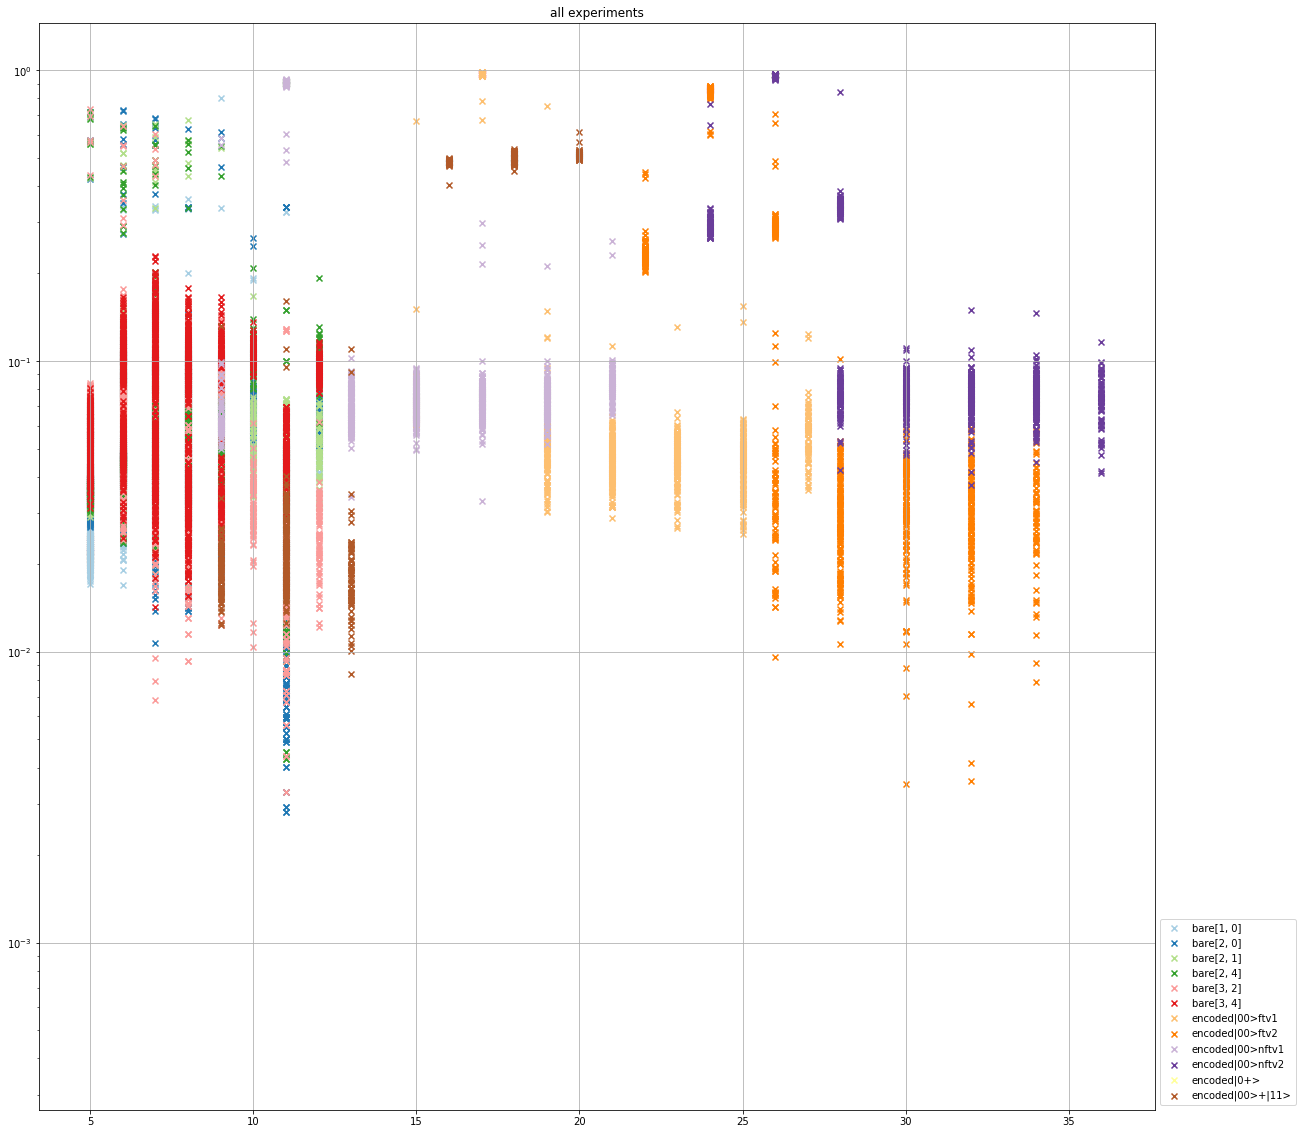

14 17855


In [166]:
exptool.plot_everything_binned('data/Processed_data/')

In [54]:
import os

In [130]:
importlib.reload(exptool)

<module 'tools.Experiment_tools' from '/Users/cvuillot/Work/Programming/IBMQE/qiskit-sdk-py/examples/experimenting_with_fault_tolerance/tools/Experiment_tools.py'>

In [131]:
file_list = os.listdir('data/Processed_data/')
n=0
for filename in file_list:
    n += exptool.repair_processed_data('data/Processed_data/'+filename, new_ext='')
    print(n)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
15
27
36
36
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
40
40
40
40
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
63
85
105
109
128
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
145
